In [1]:
%matplotlib notebook

For a better 'feel' regarding the distribution of the larvae in space we also plot all the trajectories relative to the source

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import json
import math
import pickle
import pandas as pd
from skimage import draw
from scipy.signal import find_peaks
from scipy.ndimage.interpolation import affine_transform
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# This will change to the default sans-serif font
plt.rcParams["font.family"] = "sans-serif"
# This defines that the default will be Helvetica
#plt.rcParams["font.sans-serif"] = "Arial"
import matplotlib.patches as mpatches
import os
from pathlib import Path
import shutil

In [3]:
home_path = os.getcwd()
print(home_path)

G:\My Drive\PhD\Papers\RasPi larval tracker\InitialDraft\pivr_publication\Figure 2


In [4]:
# all the figures will be saved in this folder
target_path = Path('plots/')
os.chdir(home_path)
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [5]:
# Randomly subsample as the n for the real odor is higher compared to the virtual reality
# experiments - Can only do it once, of course. Will test if subsample folder
# already exists and will only copy data in case it does NOT.
subsample_data_path_IAA = Path('data/MS74xMS133/subsample/IAA')
original_data_path_IAA = Path('data/MS74xMS133/original/IAA')

subsample_data_path_paraffin = Path('data/MS74xMS133/subsample/Paraffin')
original_data_path_paraffin = Path('data/MS74xMS133/original/Paraffin')


def subsample(subsample_folder, original_folders):
    print('Working on: ' + repr(subsample_folder))
    if os.path.isdir(Path(home_path,subsample_folder)):
        print('Already subsampled!')
    else:
        print('Subsampling now..')
        os.chdir(Path(home_path, original_folders))
        #os.chdir(datapath)
        original_data = [p.replace('\\', '') for p in glob('*MS74*')]
        # Create array from 0 to number of folders and randomly permutate the order
        random_sequence = np.random.permutation(np.arange(0,len(original_data)))
        print('Will take folder #: ' + repr(random_sequence[0:30]))

        for counter, i_folder in enumerate(random_sequence):
            if counter <= 29:
                #print(i_folder)
                print(original_data[i_folder])

                shutil.copytree(original_data[i_folder], 
                                    Path(home_path, subsample_folder, original_data[i_folder]))


subsample(subsample_data_path_IAA, original_data_path_IAA)
subsample(subsample_data_path_paraffin,original_data_path_paraffin)

Working on: WindowsPath('data/MS74xMS133/subsample/IAA')
Subsampling now..
Will take folder #: array([30, 11, 20,  8, 32, 13, 26, 28, 24, 15,  6, 27, 19, 25,  3, 17, 18,
       10, 12, 23, 31,  4, 22,  5, 21,  0, 14,  9,  2,  1])
2019.11.19_18-37-32_MS74xMS133
2019.11.18_17-26-47_MS74xMS133
2019.11.19_17-28-42_MS74xMS133
2019.11.18_17-42-32_MS74xMS133
2019.11.19_18-20-52_MS74xMS133
2019.11.18_16-53-19_MS74xMS133
2019.11.19_18-35-45_MS74xMS133
2019.11.19_18-03-01_MS74xMS133
2019.11.19_16-40-16_MS74xMS133
2019.11.18_17-08-08_MS74xMS133
2019.11.17_17-03-14_MS74xMS133
2019.11.19_18-18-10_MS74xMS133
2019.11.19_17-44-40_MS74xMS133
2019.11.19_18-34-10_MS74xMS133
2019.11.17_17-40-07_MS74xMS133
2019.11.19_18-16-39_MS74xMS133
2019.11.19_18-01-12_MS74xMS133
2019.11.18_16-54-31_MS74xMS133
2019.11.18_17-13-18_MS74xMS133
2019.11.19_17-06-06_MS74xMS133
2019.11.19_17-31-16_MS74xMS133
2019.11.17_17-38-46_MS74xMS133
2019.11.19_17-26-21_MS74xMS133
2019.11.17_17-23-16_MS74xMS133
2019.11.19_17-07-57_MS74xM

In [6]:
datapath = Path('data/MS74xMS133/subsample/IAA')
os.chdir(home_path)
os.chdir(datapath)

folders_IAA = [p.replace('\\', '') for p in glob('*MS74*')]

datapoints_stim = 0

IAA_max_coordinates = np.zeros((2,len(folders_IAA)))

for i in range(len(folders_IAA)):
    os.chdir(home_path)
    os.chdir(datapath)
    
    os.chdir(folders_IAA[i])
    #print(folders_IAA[i])

    files = [p.replace('\\', '') for p in glob('*')]
    # find the data_file.csv to get the distance to source of the centroid
    for file in files:
        if 'data.csv' in file:
            data = pd.read_csv(file)
            
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        fps = experiment_settings['Framerate']
        pixel_per_mm = experiment_settings['Pixel per mm']
        IAA_max_coordinates[:,i] = experiment_settings['Source y'], experiment_settings['Source x']
    if i ==0:
        all_pixel_per_mm_IAA = np.zeros(len(folders_IAA))
    all_pixel_per_mm_IAA[i] = pixel_per_mm
    
    y = np.asarray(data['Y-Centroid'])
    x = np.asarray(data['X-Centroid'])
    if i == 0:
        centroid_coordinates_IAA = np.zeros((x.shape[0],2,len(folders_IAA)))
    centroid_coordinates_IAA[:, 0, i] = y
    centroid_coordinates_IAA[:, 1, i] = x  

In [7]:
def own_red_colormap():
    """
    Originally I modified the 'Reds' colormap. The problem was that at value 0 it was still a bit red and 
    not white.
    I'm using the starting values Reds for the green and blue channel. 
    The red channels stays always on one.
    Finally, the inverted(!) array is passed to LinearSegmentedColormap to create the cmap object
    to be used for plotting
    """
    own_colors = np.zeros((120,4))
    own_colors[:,0] = 1 # red channel
    own_colors[:,1] = np.linspace(0.41279508, 1, own_colors.shape[0]) # green channel
    own_colors[:,2] = np.linspace(0.28835063, 1, own_colors.shape[0]) # blue channel
    own_colors[:,3] = 1
    
    own_colormap = LinearSegmentedColormap.from_list('Lower Half', own_colors[::-1,:])
    
    return(own_colormap)

own_red_cmap = own_red_colormap()

In [8]:
def plot_line_centered(max_stim_coordinate,
                      centroid_coordinates,
                      ID,
                      px_per_mm,
                      normalize=False,
                      arena = None):
    
    normalize_px_mm_to = 5

    fig=plt.figure(figsize=(7,5.25))
    ax=fig.add_subplot(111)
    ax.set_rasterization_zorder(1)
    if arena is not None:
        # get the virtual arena in uW/mm2
        # TODO: MEASURE AGAIN
        measured_light_intensity = 2
        # max value in stim file is 40000
        arena_in_uW_mm = arena*(measured_light_intensity/65535)
        
        ############################
        ax.imshow(arena_in_uW_mm, cmap=own_red_cmap, zorder=-1)
        
        
    # center the maximum value and the corresponding x/y values
    for i in range(max_stim_coordinate.shape[1]):
        y_shift = (480/2-max_stim_coordinate[0,i])
        x_shift = (640/2-max_stim_coordinate[1,i])
        shifted_y = centroid_coordinates[30:-30,0,i] + y_shift
        shifted_x = centroid_coordinates[30:-30,1,i] + x_shift
        '''        
        # On second thought - don't align to pixel per mm! Problem is that the arena is fixed in space
        # I shouldn't put a scalebar - better to indicate where we are using a low intensity background 
        # of the stimulation.
        # Even though I can normalize the IAA experiments, I don't think I should do it as it should
        # be intuitively comparable to the other two plots (gaussian and volcano which I can't zoom in/out)
        # ALSO, THE CODE SEEMS TO HAVE A BUG SOMEWHERE!!
        if normalize:

            # Must adapt to different Pixel per mm! Normalize to 5 (largest is 4.84)
            current_scale_factor = normalize_px_mm_to/px_per_mm[i]
            #print(current_scale_factor)

            # try this first: run a loop that calculates the relative change to the midpoint (320,240) and 
            # multiplies it with the current_scale_factor. I don't *think* I have to do any geometry...
            for i_zoom in range(shifted_y.shape[0]):
                temp_y = (shifted_y[i_zoom] - 240) * current_scale_factor
                temp_x = (shifted_x[i_zoom] - 320) * current_scale_factor

                shifted_y[i_zoom] += temp_y
                shifted_x[i_zoom] += temp_x        
        '''
        #ax.scatter(x=shifted_x,
        #           y=shifted_y,alpha=0.01, c='k')
        ax.plot(shifted_x,shifted_y, alpha=0.2, c='k',zorder=0)
        
    if normalize:
        #draw circles with radius 5,10,15,20 to get diameter 10,20,30 and 40mm
        for i in range(5):
            radius = (i+1)*5*np.nanmedian(pixel_per_mm)
            circle = plt.Circle((320, 240), radius, color='r', fill=False, ls=':',lw=0.5)
            ax.add_artist(circle)


    ax.set_ylim(0,480)
    ax.set_xlim(0,640)
    
    if normalize:
        # add scalebar
        fontprops = fm.FontProperties(size=18)
        scalebar = AnchoredSizeBar(ax.transData,
                               normalize_px_mm_to*20, '20mm', 
                               'lower right',
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=0.25,
                               fontproperties=fontprops)

        ax.add_artist(scalebar)
    ax.tick_params(
        axis='both',          # changes apply to the both axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the left edge are off
        labelbottom=False,
        labelleft=False) 
    
    os.chdir(home_path)
    os.chdir(target_path)
  
    fig.savefig(ID + '_tracjectories.eps', rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


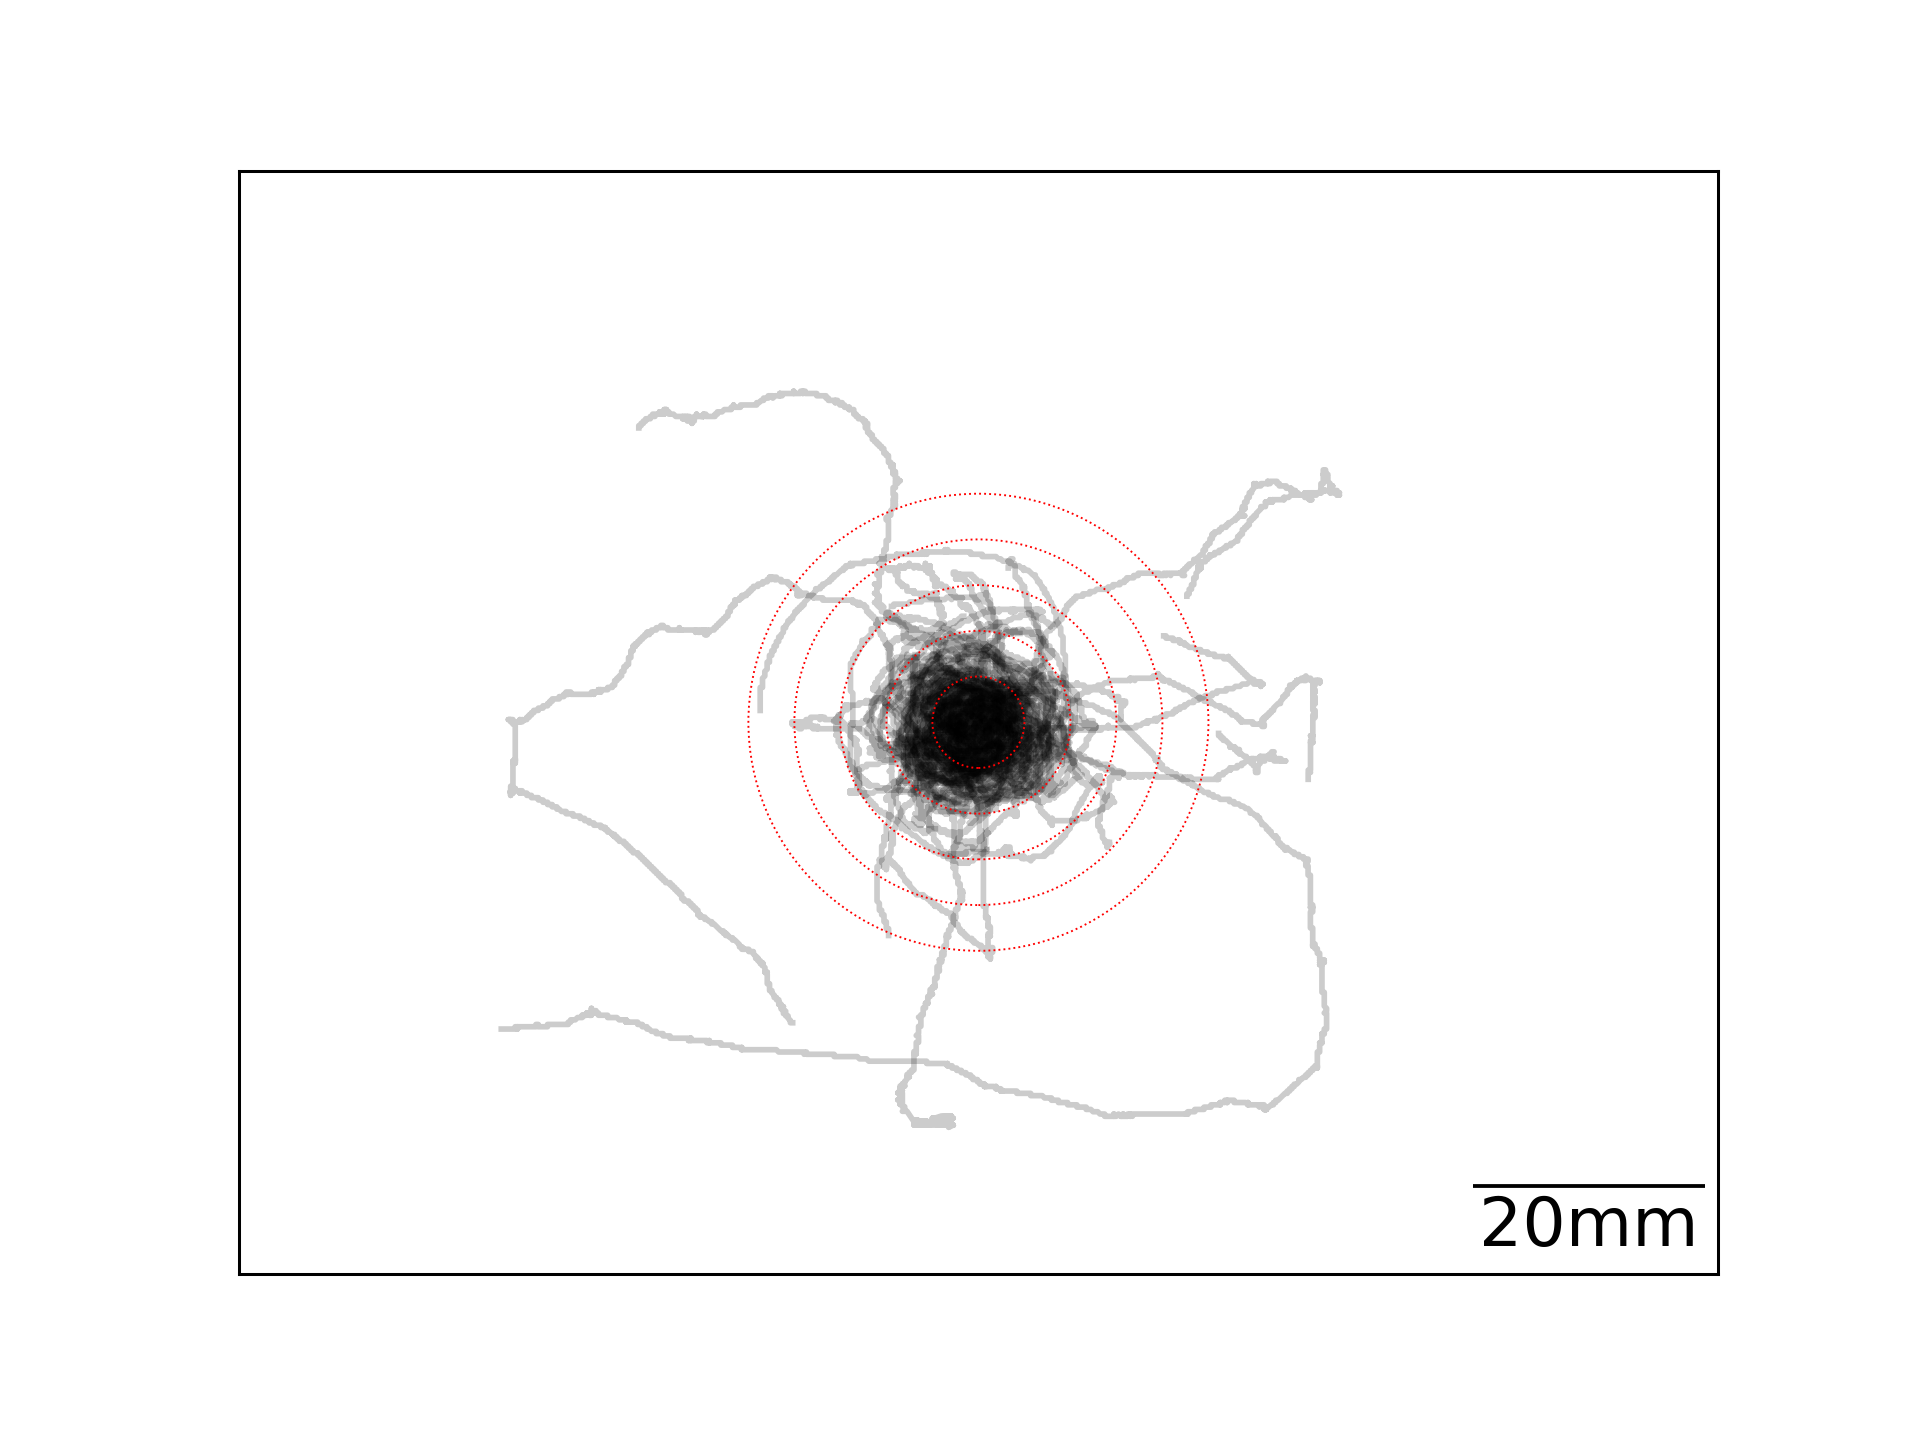

In [9]:
plot_line_centered(IAA_max_coordinates,
                  centroid_coordinates_IAA,
                  'Fig2dii_IAA',
                  all_pixel_per_mm_IAA, 
                  normalize=True)

In [17]:
############################
# Collect Gaussian-VR data #
############################
data_path_gauss = Path('data/MS379xMS133/gaussian_VR_arena/')
os.chdir(home_path)
os.chdir(data_path_gauss)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob('*/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
gauss_max_coordinates = np.zeros((2,len(folders)))
gauss_max_coordinates.fill(np.nan)
pixel_per_mm_gauss = np.zeros((len(folders)))
pixel_per_mm_gauss.fill(np.nan)
recording_time_gauss = np.zeros((1, len(folders)))
recording_time_gauss.fill(np.nan)
fps_gauss = np.zeros((1, len(folders)) )
fps_gauss.fill(np.nan)
real_animal_angle = np.zeros((1, len(folders)))
real_animal_angle.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_gauss)
    
    os.chdir(folders[i])
    print(folders[i])
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_gauss[i] = experiment_settings['Pixel per mm']
        recording_time_gauss[:,i] = experiment_settings['Recording time']
        fps_gauss[:,i] = experiment_settings['Framerate']
    
    # get the max value - this will be the center of the gaussian peak
    files = [p.replace('\\', '') for p in glob('*')]
    # get the arena
    for j in range(len(files)):
        if 'csv' and '640x480' in files[j]:
            virtual_arena = np.genfromtxt(files[j], delimiter=',')
    # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
    # the animal)
    max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
    # just the the first one as there are only two anyways and it's only used to center the image
    gauss_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
    #print(max_arena_index)
    
    #os.chdir(data_path_gauss + folders[i])
    #print(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-centroids.npy')
        except FileNotFoundError:
            temp = np.load('centroids.npy')
        centroid_coordinates_gauss = np.zeros((temp.shape[0],2,len(folders)))
        centroid_coordinates_gauss.fill(np.nan)
    try:
        centroid_coordinates_gauss[:,:,i] = np.load('SmA-T-centroids.npy')
    except FileNotFoundError:
        centroid_coordinates_gauss[:,:,i] = np.load('centroids.npy')

21.02.2018_19-25-31_MS379xMS133
21.02.2018_16-44-52_MS379xMS133
21.02.2018_17-15-59_MS379xMS133
21.02.2018_17-28-49_MS379xMS133
21.02.2018_18-31-40_MS379xMS133
20.02.2018_18-44-30_MS379xMS133
20.02.2018_18-54-16_MS379xMS133
20.02.2018_19-09-45_MS379xMS133
20.02.2018_19-01-39_MS379xMS133
21.02.2018_16-13-30_MS379xMS133
21.02.2018_18-40-28_MS379xMS133
2018.12.23_15-13-42_MS379xMS133
2018.12.23_15-20-21_MS379xMS133
2018.12.23_15-26-32_MS379xMS133
2018.12.23_15-11-50_MS379xMS133
2018.12.23_15-18-41_MS379xMS133
2018.12.23_15-24-49_MS379xMS133
2018.12.23_15-37-25_MS379xMS133
2018.12.23_15-16-15_MS379XMS133
2018.12.23_15-22-42_MS379XMS133
2018.12.23_15-29-28_MS379XMS133
2018.12.24_14-26-13_MS379xMS133
2018.12.25_13-53-36_MS379xMS133
2018.12.25_14-00-06_MS379xMS133
2018.12.25_14-08-46_MS379xMS133
2018.12.25_13-57-36_MS379xMS133
2018.12.25_14-06-17_MS379xMS133
2018.12.25_13-57-23_MS379XMS133
2018.12.25_14-06-05_MS379XMS133
2018.12.25_14-16-15_MS379XMS133


In [18]:
arena_path = Path('data/')
os.chdir(home_path)
os.chdir(arena_path)
gauss_virtual_arena = np.genfromtxt('640x480_gaussian_centred_animal_pos[250,240,0.0].csv', delimiter=',')

In [23]:
plot_line_centered(gauss_max_coordinates,
                  centroid_coordinates_gauss,
                  'Fig2eii_VRGauss',
                  pixel_per_mm_gauss,
                  normalize=False,
                  arena = gauss_virtual_arena)

<IPython.core.display.Javascript object>

In [24]:
#####################################
# Collect Volcano VR data
#####################################

data_path_volcano = 'data/MS379xMS133/volcano_VR_arena/'
os.chdir(home_path)
os.chdir(data_path_volcano)
# find all the folders (experiments)
folders = [p.replace('\\', '') for p in glob('*/')]

# collect all the data from all the folders in this cell
# start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
# as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
# time should be similar of course...
volcano_max_coordinates = np.zeros((2,len(folders)))
volcano_max_coordinates.fill(np.nan)
pixel_per_mm_volcano = np.zeros((1, len(folders)))
pixel_per_mm_volcano.fill(np.nan)
recording_time_volcano = np.zeros((1, len(folders)))
recording_time_volcano.fill(np.nan)
fps_volcano = np.zeros((1, len(folders)) )
fps_volcano.fill(np.nan)

for i in range(len(folders)):
    os.chdir(home_path)
    os.chdir(data_path_volcano)
    
    os.chdir(folders[i])
    print(folders[i])
    if i == 0:
        try:
            temp = np.load('SmA-T-heads.npy')
        except FileNotFoundError:
            temp = np.load('heads.npy')
        all_heads_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_heads_volcano.fill(np.nan)
        all_centroids_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
        all_centroids_volcano.fill(np.nan)
    try:
        all_heads_volcano[:,:,i] = np.load('SmA-T-heads.npy')
        all_centroids_volcano[:,:,i] = np.load('SmA-T-centroids.npy')
    except FileNotFoundError:
        all_heads_volcano[:,:,i] = np.load('heads.npy')
        all_centroids_volcano[:,:,i] = np.load('centroids.npy')
    
    if i == 0:
        temp = np.load('stimulation.npy')
        all_stimulations_volcano = np.zeros((temp.shape[0], len(folders)))
    all_stimulations_volcano[:,i] = np.load('stimulation.npy')
    
    with open(('experiment_settings.json'), 'r') as file:
        experiment_settings = json.load(file)
        pixel_per_mm_volcano[:,i] = experiment_settings['Pixel per mm']
        recording_time_volcano[:,i] = experiment_settings['Recording time']
        fps_volcano[:,i] = experiment_settings['Framerate']
    
    # find all files and look for the csv file that saved the presented arena
    files = [p.replace('\\', '') for p in glob('*')]
    # get the arena
    for j in range(len(files)):
        if 'csv' and '640x480' in files[j]:
            if i == 0:
                temp = np.genfromtxt(files[j], delimiter=',')
                virtual_arenas_volcano = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
                # this array will be used to turn the smooth vulcano into a binary ring (see below)
                max_values_arenas = np.empty_like(virtual_arenas_volcano)
            # save all the virtual volcanoe arenas
            virtual_arenas_volcano[:,:,i] = np.genfromtxt(files[j], delimiter=',')
            
        # it is now necessary to define a useful metric for closeness to the maximum. Maybe everything above 99% of the maximum 
    # counting as the maximum would be good?
    max_values_arenas[:,:,i] = virtual_arenas_volcano[:,:,i] > 0.99*np.amax(virtual_arenas_volcano[:,:,i])

21.02.2018_17-46-38_MS379xMS133
21.02.2018_17-53-27_MS379xMS133
21.02.2018_18-00-52_MS379xMS133
21.02.2018_18-22-11_MS379xMS133
21.02.2018_18-45-50_MS379xMS133
21.02.2018_18-58-37_MS379xMS133
21.02.2018_19-19-17_MS379xMS133
21.02.2018_19-32-27_MS379xMS133
21.02.2018_17-49-17_MS379xMS133
21.02.2018_17-57-17_MS379xMS133
21.02.2018_18-04-23_MS379xMS133
21.02.2018_18-33-43_MS379xMS133
21.02.2018_18-53-07_MS379xMS133
21.02.2018_19-06-04_MS379xMS133
21.02.2018_19-26-58_MS379xMS133
2018.12.23_15-41-19_MS379xMS133
2018.12.23_15-50-18_MS379xMS133
2018.12.23_15-43-47_MS379xMS133
2018.12.23_15-44-13_MS379XMS133
2018.12.23_15-52-57_MS379XMS133
2018.12.24_14-18-36_MS379XMS133
2018.12.24_14-25-02_MS379XMS133
2018.12.24_14-15-03_MS379xMS133
2018.12.24_14-21-05_MS379xMS133
2018.12.24_14-13-11_MS379xMS133
2018.12.25_14-17-53_MS379xMS133
2018.12.25_14-13-08_MS379xMS133
2018.12.25_14-21-02_MS379xMS133


In [25]:
arena_path = Path('data/')
volcano_virtual_arena = np.genfromtxt('640x480_volcano_animal_pos[320,240,0.0].csv', delimiter=',')

In [26]:
#def plot_line_centered_volcaon(max_stim_coordinate,
#                      centroid_coordinates):
normalize_px_mm_to = 5

fig=plt.figure(figsize=(7,5.25))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

# get the virtual arena in uW/mm2
# TODO: MEASURE AGAIN
measured_light_intensity = 2
# max value in stim file is 40000
volcano_in_uW_mm = volcano_virtual_arena*(measured_light_intensity/65535)

#############################


ax.imshow(volcano_in_uW_mm, cmap=own_red_cmap, zorder=-1)

# take the minimum row and the minimum column and use it to center all the trajectories
for i in range(all_heads_volcano.shape[2]):
    min_row = np.amin(np.where(max_values_arenas[:,:,i] == 1)[0])
    min_col = np.amin(np.where(max_values_arenas[:,:,i] == 1)[1])
    diameter = np.amax(np.where(max_values_arenas[:,:,i] == 1)[1])-min_col
    
    y_shift = (480/2-((diameter/2) + min_row))
    x_shift = (640/2-((diameter/2) + min_col))
    shifted_y = all_heads_volcano[30:-30,0,i] + y_shift
    shifted_x = all_heads_volcano[30:-30,1,i] + x_shift
    
    #print(i)
    #print(px_per_mm)
    #print(px_per_mm[i])
    # Must adapt to different Pixel per mm! Normalize to 5 (largest is 4.84)
    current_scale_factor = normalize_px_mm_to/pixel_per_mm_volcano[0][i]
    print(current_scale_factor)

    ax.plot(shifted_x,shifted_y, alpha=0.2, c='k',zorder=0)
    

#draw circles with radius 5,10,15,20 to get diameter 10,20,30 and 40mm
#for i in range(2):
#    radius = (i+1)*5*pixel_per_mm
#    circle = plt.Circle((320, 240), radius, color='r', fill=False, ls=':',lw=2)
#    ax.add_artist(circle)

ax.set_ylim(0,480)
ax.set_xlim(0,640)

ax.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 
  
os.chdir(home_path)
os.chdir(target_path)
fig.savefig('Fig2fii_volcanoTracjectories.eps')#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>

1.1210762331838564
1.1210762331838564
1.1210762331838564
1.1210762331838564
1.1210762331838564
1.1210762331838564
1.1210762331838564
1.1210762331838564
1.004016064257028
1.004016064257028
1.004016064257028
1.004016064257028
1.004016064257028
1.004016064257028
1.004016064257028
1.1520737327188941
1.1520737327188941
1.234567901234568
1.278772378516624
1.278772378516624
1.278772378516624
1.278772378516624
1.234567901234568
1.234567901234568
1.2285012285012284
1.2285012285012284
1.234567901234568
1.234567901234568
